In [67]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.decomposition import PCA

In [68]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [69]:
folder = "../00_Raw_Data/"

# Generate filenames from 2015_Q1 to 2022_Q4
years = range(2015, 2023)
quarters = range(1, 5)

files = ["{}_Q{}_Traffic_Crashes.csv".format(year, quarter) for year in years for quarter in quarters]

dfs = [pd.read_csv(folder + file) for file in files]
df = pd.concat(dfs, ignore_index=True)

In [70]:
df['collision_date'] = pd.to_datetime(df['collision_date'], format='%m/%d/%Y %I:%M:%S %p')
df['date'] = df['collision_date'].dt.date

df['day_of_week'] = df['collision_date'].dt.dayofweek # 0: Monday - 6: Sunday
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

df['time'] = df['collision_date'].dt.time
df['hour'] = df['collision_date'].dt.hour
df['month'] = df['collision_date'].dt.month
df['year'] = df['collision_date'].dt.year
df['covid'] = (df['date'] >= pd.Timestamp('2020-03-15').date()).astype(int)

def time_window(hour):
    if 23 <= hour or hour < 5:
        return 'late night'
    elif 5 <= hour < 11:
        return 'morning'
    elif 11 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 23:
        return 'night'
    else:
        return 'unknown' 
df['time_window'] = df['hour'].apply(time_window)

columns_to_convert = ['pedestrian', 'bicycle', 'scooter', 'hitrun', 'parking']

for column in columns_to_convert:
    df[column] = df[column].map({'yes': 1, 'no': 0})

In [71]:
df['manner_of_crash'] = df['manner_of_crash'].fillna('Unknown/Missing')
df['manner_of_crash'] = df['manner_of_crash'].replace(['Missing', 'Unknown'], 'Unknown/Missing')
crash_onehot = pd.get_dummies(df['manner_of_crash'], prefix='crash')
df = pd.concat([df, crash_onehot], axis=1)
df.drop('manner_of_crash', axis=1, inplace=True)

# top_100_roads = df['roadway_name'].value_counts().head(100).index

# df['roadway_grouped'] = np.where(df['roadway_name'].isin(top_100_roads), df['roadway_name'], 'Other')
# roadway_onehot = pd.get_dummies(df['roadway_grouped'], prefix='road')
# df = pd.concat([df, roadway_onehot], axis=1)
# df.drop('roadway_grouped', axis=1, inplace=True)
df.drop('roadway_name', axis=1, inplace=True)

df['intersect_type'].replace(['OTHER', 'Missing', 'Unknown'], 'Unknown/Other', inplace=True)
intersect_type_onehot = pd.get_dummies(df['intersect_type'], prefix='intersect_type')
df = pd.concat([df, intersect_type_onehot], axis=1)
df.drop('intersect_type', axis=1, inplace=True)

df['relation_to_junction'].replace(['Missing', 'OtherLocation', 'Unknown'], 'Unknown/Other', inplace=True)
relation_onehot = pd.get_dummies(df['relation_to_junction'], prefix='relation_to_junction')
df = pd.concat([df, relation_onehot], axis=1)
df.drop('relation_to_junction', axis=1, inplace=True)

df['city'] = df['city'].fillna('Unknown')
city_onehot = pd.get_dummies(df['city'], prefix='city')
df = pd.concat([df, city_onehot], axis=1)
df.drop('city', axis=1, inplace=True)

In [72]:
df['intersection_indicator'] = df['intersection_indicator'].fillna("N")
df['intersection_indicator'].replace("Missing", "N", inplace=True)
mapping = {"N": 0, "Y": 1}
df['intersection_indicator'] = df['intersection_indicator'].map(mapping)
df['intersection_indicator'] = df['intersection_indicator'].astype('int64')

# Combine "Campus" and "OHO" categories
df['mou'] = df['mou'].replace('OHO', 'Campus')

# Now, encode "Campus" as 1 and "False" as 0
df['mou'] = df['mou'].apply(lambda x: 1 if x == 'Campus' else 0)

df['work_zone_type'] = df['work_zone_type'].apply(lambda x: 0 if x == "Missing" or x == "Unknown" or x is None else 1)

In [73]:
def simplify_weather(weather):
    if pd.isna(weather):
        return 'Unknown/Other'
    elif 'Snow' in weather:
        return 'Snow'
    elif 'Sleet/Hail' in weather:
        return 'Sleet/Hail'
    elif 'Rain' in weather:
        return 'Rain'
    elif weather in ['Fog', 'Smoke', 'Smog']:
        return 'Fog'
    elif 'Cloudy' in weather:
        return 'Cloudy'
    elif weather == 'Clear':
        return 'Clear'
    elif weather in ['Missing', 'Unknown', 'Other']:
        return 'Unknown/Other'
    else:
        return 'Other Conditions'

df['simplified_weather'] = df['weather_condition(s)'].apply(simplify_weather)
df = pd.get_dummies(df, columns=['simplified_weather'], prefix='weather')
df.drop('weather_condition(s)', axis=1, inplace=True)

In [74]:
def bool_to_int(df):
    for col in df.select_dtypes(['bool']).columns:
        df[col] = df[col].astype(int)
    return df

df = bool_to_int(df)

In [75]:
columns_to_scale = ['latitude', 'longitude', 'vehicles_involved', 'number_injured', 'number_dead', 'year']
scaler = StandardScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2. * np.pi / 7))
df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2. * np.pi / 7))
df.drop('day_of_week', axis=1, inplace=True)
df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))
df.drop('hour', axis=1, inplace=True)
df['month_sin'] = np.sin((df['month'] - 1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df['month'] - 1) * (2. * np.pi / 12))
df.drop('month', axis=1, inplace=True)

In [76]:
df['time'] = df['time'].astype(str)
df['time'] = df['time'].str.strip()
has_time_df = df[df['time'] != "00:00:00"]

In [77]:
columns_to_drop = [
    "master_record_number", "agency", "agency_tracking_number", "county", 
    "collision_date", "roadway_suffix", "roadway_number", "roadway_local_id", 
    "distance_from_reference", "miles-feet_indicator", "direction_from_reference",
    "intersection_road_name", "intersection_road_name_suffix", "intersection_road_number",
    "intersection_local_id", "mile_marker", "interchange_related_indicator", 
    "construction_maintenance_zone", "construction_maintenance_zone_location",
    "fatal_case_number", "date", "officer_first_name", "officer_last_name", "time"
]

has_time_df = has_time_df.drop(columns=columns_to_drop)

In [78]:
has_time_no_time_window_df = has_time_df.drop('time_window', axis=1)

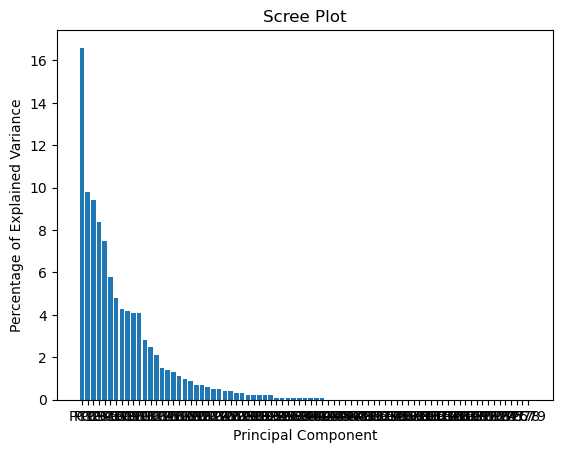

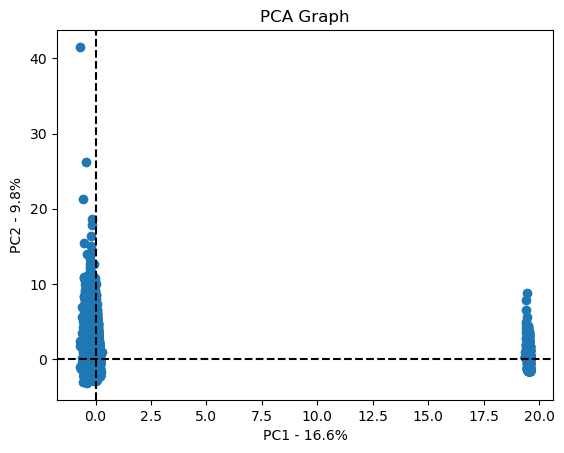

latitude                                               7.000267e-01
longitude                                              7.000086e-01
year                                                   1.317355e-01
covid                                                  4.108305e-02
hour_sin                                               1.433830e-02
number_injured                                         9.853985e-03
intersection_indicator                                 8.006384e-03
month_sin                                              7.927625e-03
number_dead                                            7.401510e-03
city_Nashville                                         7.157202e-03
intersect_type_Not at Intersection                     7.124266e-03
month_cos                                              6.989708e-03
vehicles_involved                                      6.726956e-03
intersect_type_T-Intersection                          5.596920e-03
city_Antioch                                    

In [79]:
pca = PCA()  # You can specify, e.g., PCA(n_components=0.95) to get the number of components that explain 95% of the variance
pca.fit(has_time_no_time_window_df)

# Transform the scaled data using the PCA model
pca_data = pca.transform(has_time_no_time_window_df)

# Create a DataFrame with the PCA data
# np.arange starts arrays from 0, so +1 to match the number convention starting from 1
pca_df = pd.DataFrame(pca_data, columns=['PC' + str(i) for i in np.arange(has_time_no_time_window_df.shape[1]) + 1])

# Plot the Scree plot
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

# You can adjust the following code to plot any two PCs
# Here we are plotting PC1 and PC2
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA Graph')
plt.xlabel(f'PC1 - {per_var[0]}%')
plt.ylabel(f'PC2 - {per_var[1]}%')
plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

# To find out which features influence PC1 the most, you can look at the absolute values of the PCA components
loading_scores = pd.Series(pca.components_[0], index=has_time_no_time_window_df.columns)  # Get the loading scores for PC1
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)  # Sort the loading scores

# Print the names of the features and their loading scores for PC1
print(sorted_loading_scores)

In [82]:
# Calculate the total counts for each 'hitrun' category
total_counts = df.groupby('hitrun')['time_window'].count().reset_index(name='total')

# Merge the total counts back to the combo_counts dataframe
combo_counts = combo_counts.merge(total_counts, on='hitrun')

# Calculate the percentage for each 'time_window' within each 'hitrun' category
combo_counts['percentage'] = (combo_counts['count'] / combo_counts['total']) * 100

# Display the updated dataframe
print(combo_counts[['hitrun', 'time_window', 'count', 'percentage']])


   hitrun time_window  count  percentage
0       0   afternoon  84422   38.901100
1       0  late night  22238   10.247123
2       0     morning  54277   25.010483
3       0       night  56080   25.841294
4       1   afternoon  18876   30.110065
5       1  late night  15748   25.120434
6       1     morning   9845   15.704259
7       1       night  18221   29.065242
